<a href="https://colab.research.google.com/github/S-Kitaev/TimeSeriesPredictions/blob/main/exp1_statistics_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Изучение  моделей сглаживания временных рядов (скользящей средней; простого, двойного и тройного экспоненциального сглаживания Тейла-Вейджа) и кросс-валидации на временных рядах (RMSE, MAE, MAPE)

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
import matplotlib.pyplot as plt

### В качестве примера для работы возьмем реальные данные (рис. 6.2) по часовому онлайну игроков в одной из мобильных игрушек. Нарисуем исходные данные. (https://github.com/Yorko/mlcourse.ai/blob/master/data/hour_online.csv)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/MyDrive/Colab Notebooks/ML_sems/time_series/hour_online.csv"
dataset = pd.read_csv(data_path)

dataset.head(5)

Mounted at /content/drive


,Time,Users
0,1/1/17 0:00,34002
1,1/1/17 1:00,37947
2,1/1/17 2:00,41517
3,1/1/17 3:00,44476
4,1/1/17 4:00,46234


### Преобразуем столбец Time в формат timestamp

In [3]:
dataset['Time'] = pd.to_datetime(dataset['Time'])
display(dataset.head())

/tmp/ipython-input-2480914327.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['Time'] = pd.to_datetime(dataset['Time'])


,Time,Users
0,2017-01-01 00:00:00,34002
1,2017-01-01 01:00:00,37947
2,2017-01-01 02:00:00,41517
3,2017-01-01 03:00:00,44476
4,2017-01-01 04:00:00,46234


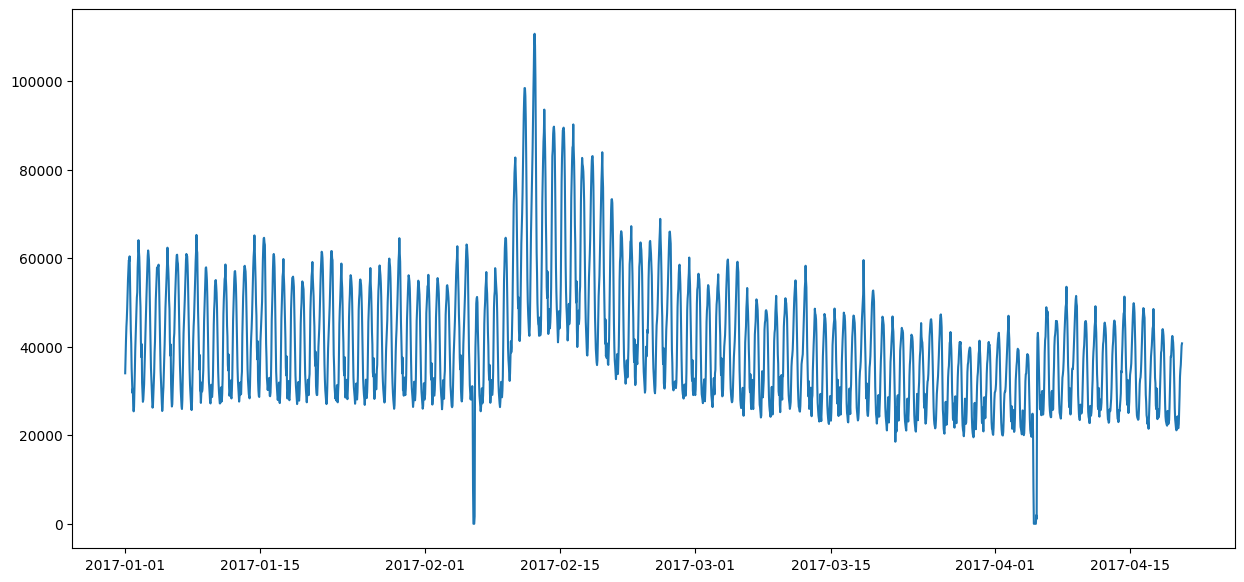

In [4]:
plt.figure(figsize=(15,7))
plt.plot(dataset['Time'],dataset['Users'])
plt.show()

### Выведем общие статистики по данному временному ряду

In [5]:
print(dataset["Users"].describe())
print("Размер датасета:", len(dataset), "почасовых записей")
print("В датасете:", int(len(dataset)/24), "дней")

count      2625.000000
mean      40483.884190
std       14304.659157
min           0.000000
25%       29346.000000
50%       38314.000000
75%       48996.000000
max      110716.000000
Name: Users, dtype: float64
Размер датасета: 2625 почасовых записей
В датасете: 109 дней


### Верхнеуровневое описание

1) На графике присутствует 2 выброса с 0 посещений в день
2) График с ярковыраженной ассиметрией в виду бизнес-события
3) Ярко выражена сезонность по дням
4) График схож с колебанием случайной величины вокруг среднего значения


### Напишем функцию по оценке качества предсказания (RSME)

In [6]:
def RMSE(target, predict):
    return np.sqrt(np.mean((target - predict)**2))

### Модель скользящей средней

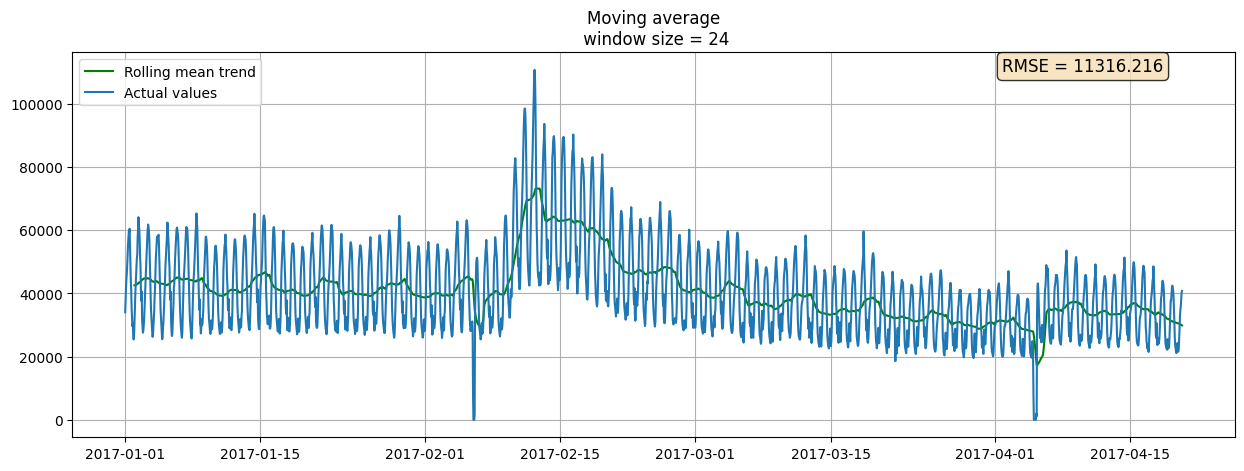

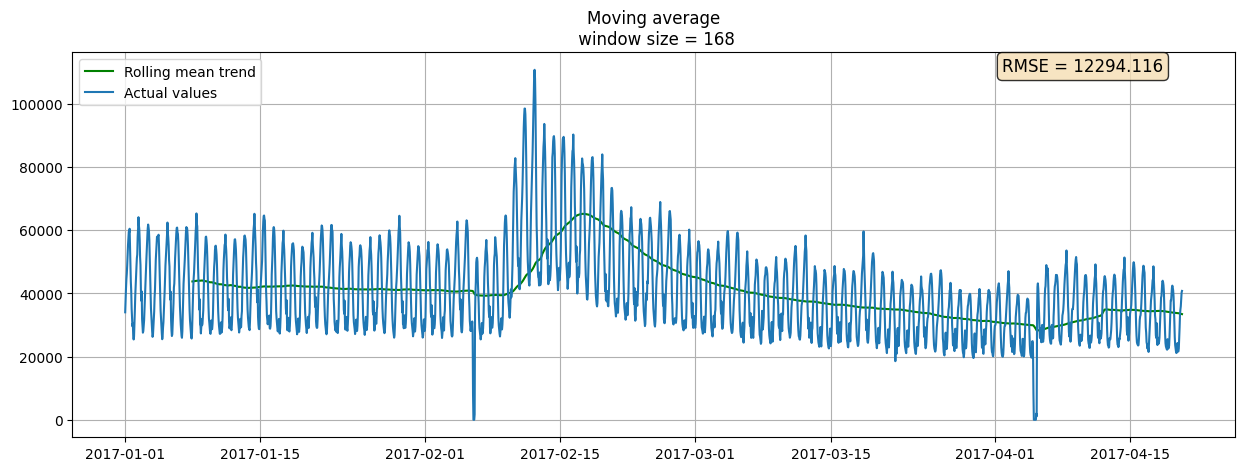

In [7]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size

    """

    # Calculate rolling mean on the 'Users' column
    rolling_mean = series['Users'].rolling(window=n).mean()

    # Plotting
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(series['Time'], rolling_mean, "g", label="Rolling mean trend")

    # Optional: Plotting confidence intervals
    # rolling_std =  series['Users'].rolling(window=n).std()
    # upper_bond = rolling_mean+1.96*rolling_std
    # lower_bond = rolling_mean-1.96*rolling_std
    # plt.plot(series['Time'], upper_bond, "r--", label="Upper Bond / Lower Bond")
    # plt.plot(series['Time'], lower_bond, "r--")

    plt.plot(series['Time'], series['Users'], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

    rmse = RMSE(series['Users'].iloc[n:], rolling_mean)

    plt.text(0.80, 0.95, f'RMSE = {rmse:.3f}', transform=plt.gca().transAxes,
         fontsize=12, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))


plotMovingAverage(dataset, 24) # сглаживаем по дням
plotMovingAverage(dataset, 24*7) # сглаживаем по неделям

### Найдем лучшее значение окна сглаживания, используем самописный GridSearch

Лучшее RMSE = 10041.3612265637, размер окна n = 29


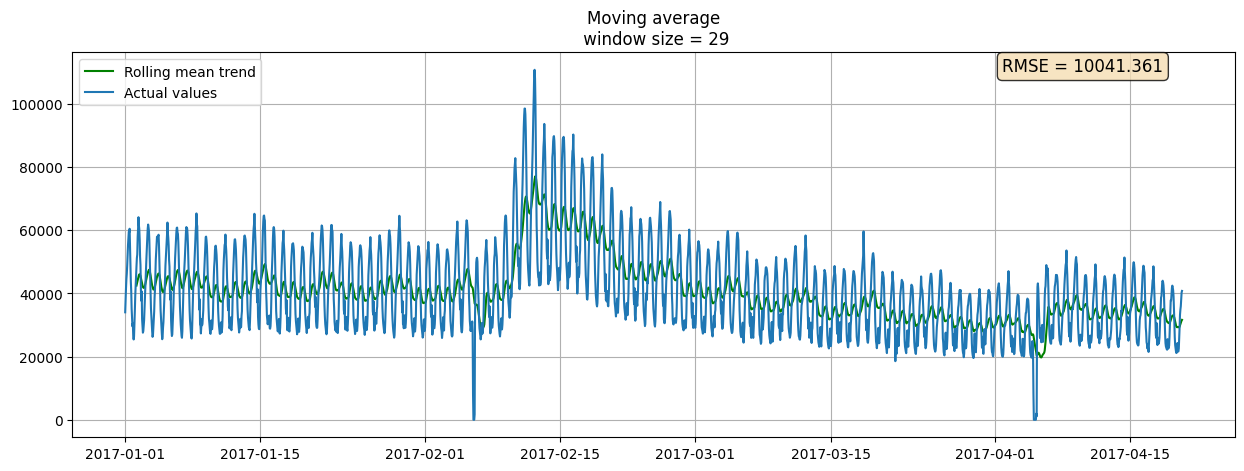

In [8]:
def best_RMSE_MovingAverage(series):
  min_n = 9 # при меньших значениях получаются
  max_n = int(len(series) / 10)

  best_rmse = 10**9
  best_n = 0

  for n in range(min_n, max_n, 4):

    rolling_mean = series['Users'].rolling(window=n).mean()
    rmse = RMSE(series['Users'].iloc[n:], rolling_mean)

    if rmse < best_rmse:
      best_rmse = rmse
      best_n = n

  print(f"Лучшее RMSE = {best_rmse}, размер окна n = {best_n}")
  return best_n


best_n = best_RMSE_MovingAverage(dataset)
plotMovingAverage(dataset, best_n)

### Экспоненциальное сглаживание, модель Тейла-Вейджа Простое экспоненциальное сглаживание(ЭСС)

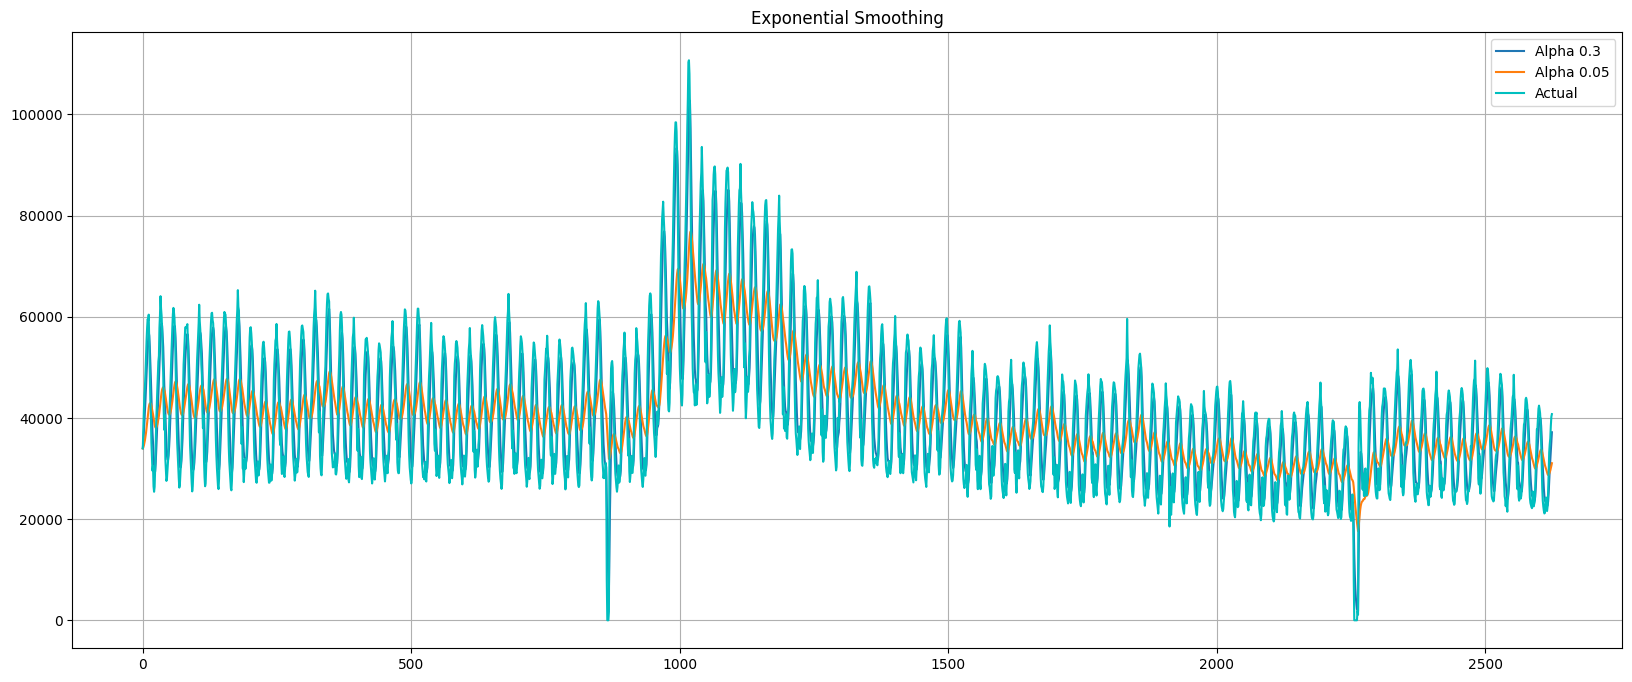

In [9]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

# with plt.style.context('seaborn-white'): # Removed the invalid style context
plt.figure(figsize=(20, 8))
for alpha in [0.3, 0.05]:
    plt.plot(exponential_smoothing(dataset.Users, alpha), label="Alpha {}".format(alpha))
plt.plot(dataset.Users.values, "c", label = "Actual")
plt.legend(loc="best")
plt.axis('tight')
plt.title("Exponential Smoothing")
plt.grid(True)

### Двойное экспоненциальное сглаживание

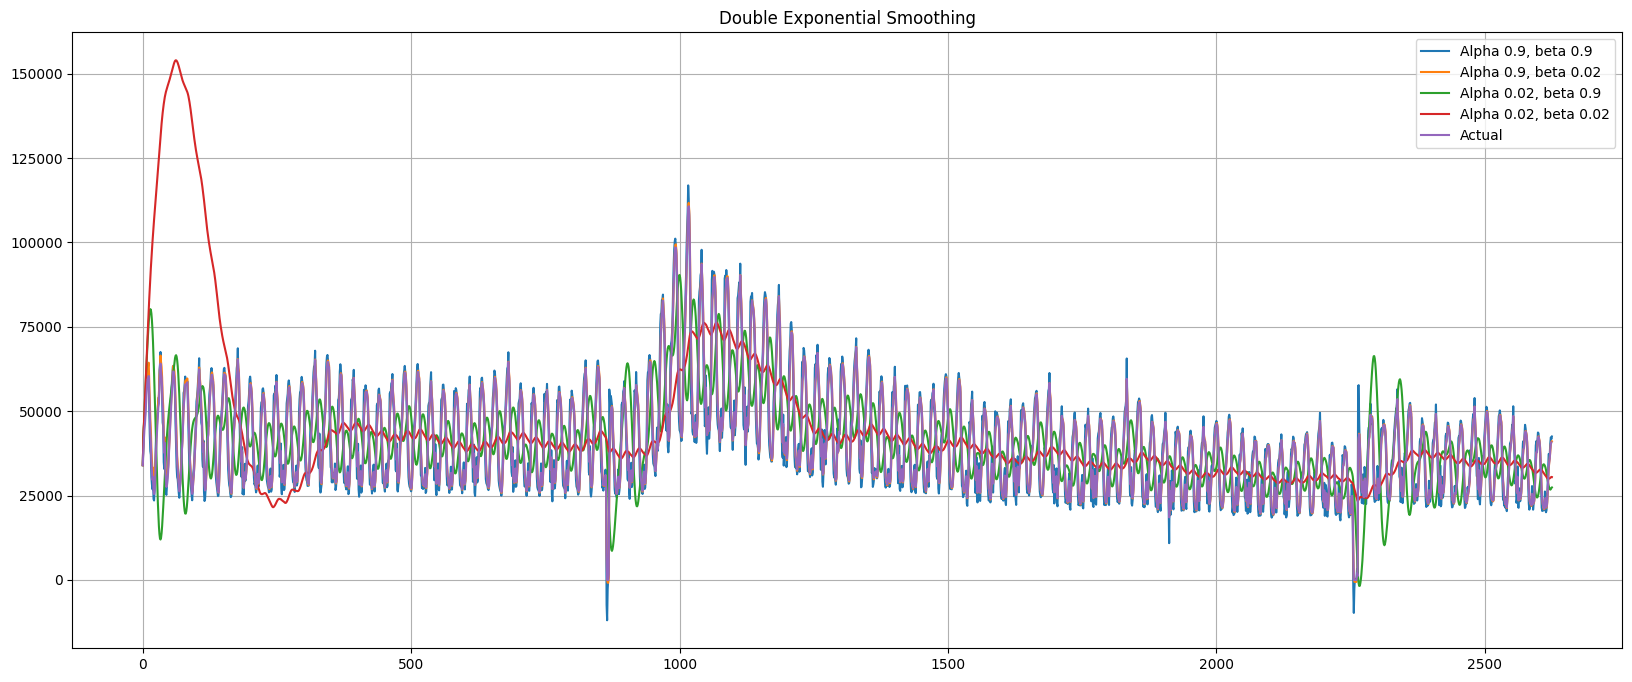

In [10]:
def double_exponential_smoothing(series, alpha, beta):
  result = [series[0]]
  for n in range(1, len(series)+1):
    if n == 1:
      level, trend = series[0], series[1] - series[0]
    if n >= len(series): # прогнозируем
      value = result[-1]
    else:
      value = series[n]
    last_level, level = level, alpha*value + (1-alpha)*(level+trend)
    trend = beta*(level-last_level) + (1-beta)*trend
    result.append(level+trend)
  return result

plt.figure(figsize=(20, 8))
for alpha in [0.9, 0.02]:
  for beta in [0.9, 0.02]:
    plt.plot(double_exponential_smoothing(dataset.Users, alpha, beta),label="Alpha {}, beta {}".format(alpha, beta))
plt.plot(dataset.Users.values, label = "Actual")
plt.legend(loc="best")
plt.axis('tight')
plt.title("Double Exponential Smoothing")
plt.grid(True)

### Тройное экспоненциальное сглаживание(Модель Тейла–Вейджа)

In [11]:
class TheilWage:

    """
    Модель Тейла-Вейджа с методом Брутлага для детектирования аномалий

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Тейла-Вейджа
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)

        # вычисляем сезонные средние
        for j in range(n_seasons):
          season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))

        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] +
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] -
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1 - self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] +
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] -
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

### Распишем кроссвалидацию по временному ряду

In [12]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []
    values = data.values
    alpha, beta, gamma = x
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3)
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):
        model = TheilWage(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок
    return np.mean(np.array(errors))

### Строим оптимизатор для опредения оптимальных альфа, бетта, гамма

In [13]:
data = dataset.Users[:-500] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0]

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0,1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.006635880294816432 0.0 0.046569454900318885


### Визуализируем

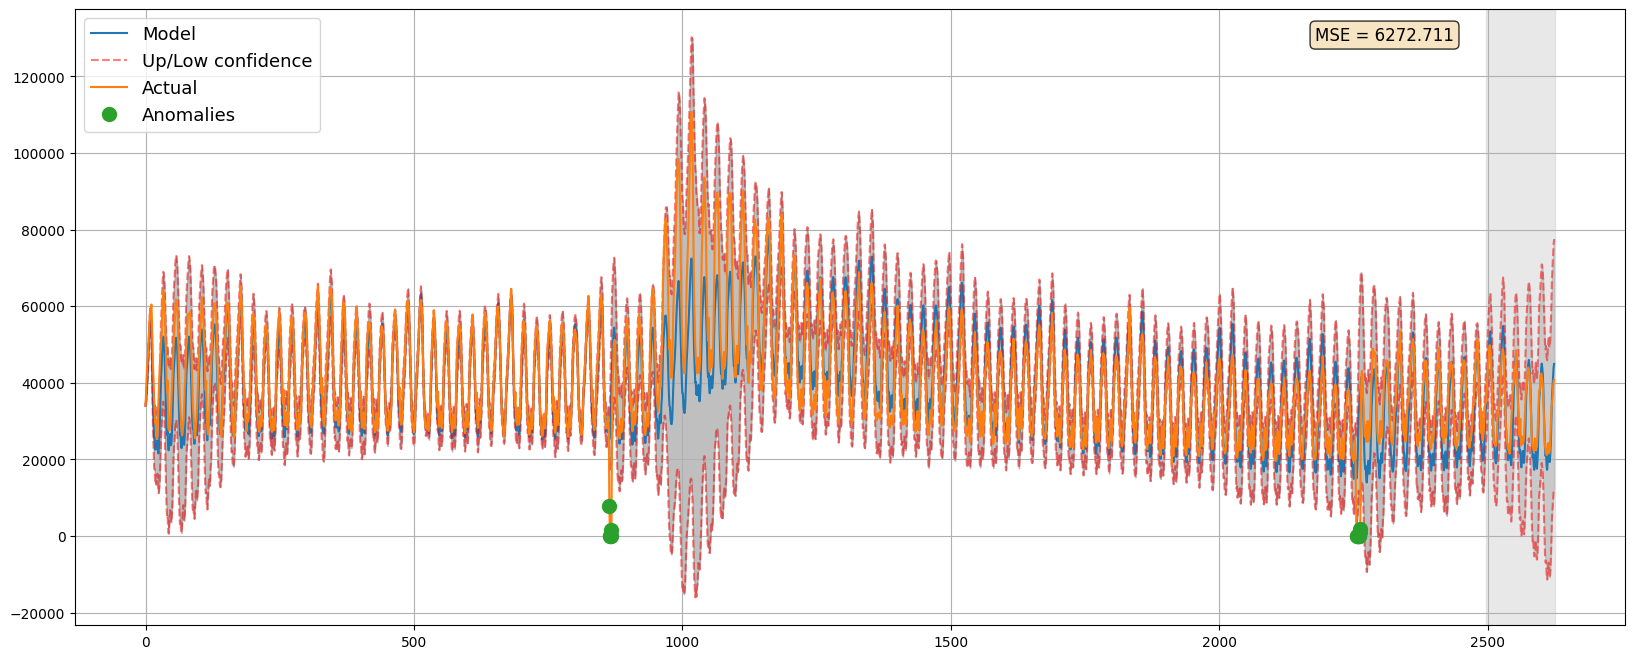

In [14]:
data = dataset.Users
model = TheilWage(data[:-128], slen = 24*7, alpha = alpha_final, beta = beta_final,
gamma = gamma_final, n_preds = 128, scaling_factor = 2.56)
model.triple_exponential_smoothing()

def plotTheilWage():
    Anomalies = np.array([np.nan]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(20, 8))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

    rmse = RMSE(data.values, model.result)

    plt.text(0.80, 0.95, f'MSE = {rmse:.3f}', transform=plt.gca().transAxes,
            fontsize=12, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))


plotTheilWage()

### Реализация предсказания при помощи регрессионной модели

In [15]:
# Введем несколько условностей для реализации обычной линейной регрессии:
# Сформируем признаки, как n предыдущих значений, будем пытаться предсказать следующее
# Организуем вместо вектора признаков - матрицу признаков с нелинейными преобразования каждого из n предыдущих значений
# Так как нам необходимо фиксированное количество n предыдущих признаков, то k-fold нам не будет подходить

In [16]:
# Составим матрицу признаков, и обучим scaler, для корректной работы модели в дальнейшем
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

# Нелинейные преобразования
def nonlinear_x(x):
    x = float(x)
    return np.array([
        x,
        x**2,
        np.sin(x),
        x*np.sin(x),
        np.log(x+1),
        np.sin(1/(x + 0.001))
    ], dtype=float)

# Обучим scaler
X = np.array([nonlinear_x(x) for x in dataset["Users"].iloc[:int(len(dataset["Users"]) * 0.8)]])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled[:10])

[[-0.58730413 -0.58226879 -0.69195354 -0.52070177 -0.30061262 -0.03772441]
 [-0.31652432 -0.39172072  0.4600642   0.38672687 -0.08941867 -0.03782231]
 [-0.07148404 -0.2012749  -1.02892202 -0.95447789  0.08356886 -0.03789487]
 [ 0.13161798 -0.03045405 -0.60506267 -0.60587861  0.21602704 -0.03794619]
 [ 0.25228487  0.07660092  1.08211245  1.10297668  0.29061076 -0.03797356]
 [ 0.43129469  0.24306145  0.51857863  0.55132927  0.39618842 -0.03801054]
 [ 0.6648723   0.47399661  0.48245945  0.54537122  0.52577431 -0.03805325]
 [ 0.87078851  0.69047877 -0.08957612 -0.12787301  0.63319636 -0.03808653]
 [ 1.04101257  0.87856093  1.43875273  1.82616558  0.71768263 -0.03811143]
 [ 1.16518004  1.02096341  1.08224029  1.41044835  0.77705098 -0.03812829]]


In [17]:
# видно, что на таком количестве признаков, нас будет ждать переобучение, поэтому мы воспользуемся анализом l1 регуляризации
np.random.seed(42)

def form_train_vector(series, n_samples, idx):
    if isinstance(series, list):
        seg = series[idx-n_samples:idx]
        y_target = float(series[idx])
    else:
        seg = series.iloc[idx-n_samples:idx].values
        y_target = float(series.iloc[idx])
    feat_matrix = np.array([scaler.transform([nonlinear_x(xf)])[0] for xf in seg]).flatten()
    return feat_matrix.astype(float), y_target

def form_boost_vector(list_values):
    feat_matrix = np.array([scaler.transform([nonlinear_x(xf)])[0] for xf in list_values]).flatten()
    return feat_matrix.astype(float)

def form_train_vector_nc(series, n_samples, idx):
    if isinstance(series, list):
        seg = series[idx-n_samples:idx]
        y_target = float(series[idx])
    else:
        seg = series.iloc[idx-n_samples:idx].values
        y_target = float(series.iloc[idx])
    feat_matrix = np.array([nonlinear_x(xf) for xf in seg]).flatten()
    return feat_matrix.astype(float), y_target

def form_boost_vector_nc(list_values):
    feat_matrix = np.array([nonlinear_x(xf) for xf in list_values]).flatten()
    return feat_matrix.astype(float)

#### класс модели линейной регрессиии с l1 регуляризацией для определения фич, которые вносят наибольший вклад в результат

In [18]:
def soft_sign(x, eps=1e-7):
    x = np.asarray(x)
    signs = np.where(np.abs(x) > eps, np.sign(x), x / eps)
    return signs

class MyLassoRegression(object):
    def __init__(self, C=1.0, n_samples=5):
        self.coef_ = None
        self.intercept_ = None
        self.C = float(C)
        self.n_samples = int(n_samples)
        self.y_mean_ = 0.0  # будем хранить среднее y_train

    def regularization_term(self, weights):
        signs = soft_sign(weights)
        signs[0] = 0.0
        return signs

    def grad(self, X, y, weights):
        weights = weights.astype(float)
        if X.ndim == 1:
            y_pred = float(X @ weights)
            basic_term = 2.0 * X * (y_pred - y)
        else:
            y_pred = X @ weights
            basic_term = (2.0 / X.shape[0]) * (X.T @ (y_pred - y))
        reg = self.regularization_term(weights)
        return basic_term + self.C * reg

    def fit(self, series, idx_list, batch_size=10, max_iter=100, lr=0.01):
        y_vals = np.array([series.iloc[i] for i in idx_list], dtype=float)
        self.y_mean_ = float(np.mean(y_vals))

        sample_X, _ = form_train_vector(series, self.n_samples, idx_list[0])
        n_features = sample_X.size
        weights = np.random.randn(1 + n_features) * 0.01
        losses = []

        for iter_num in range(max_iter):
            k = np.random.choice(idx_list)
            X_batch = []
            y_batch = []

            for j in range(k, k + batch_size):
                X_train, y = form_train_vector(series, self.n_samples, j)
                X_train = np.concatenate(([1.0], X_train))
                X_batch.append(X_train)
                y_batch.append(y - self.y_mean_)

            X_batch = np.vstack(X_batch)
            y_batch = np.array(y_batch, dtype=float)

            grad = self.grad(X_batch, y_batch, weights)

            preds = X_batch @ weights
            mse = np.mean((preds - y_batch)**2)
            l1 = self.C * np.sum(np.abs(weights[1:]))
            loss = mse + l1
            losses.append(loss)

            weights = weights - (lr / np.sqrt(iter_num + 1)) * grad

        self.intercept_ = weights[0]
        self.coef_ = weights[1:].copy()
        return losses

    def predict(self, series, X_idx):
        X_test, _ = form_train_vector(series, self.n_samples, X_idx)
        X_test = np.concatenate(([1.0], X_test))
        y_pred_centered = float(X_test @ np.concatenate(([self.intercept_], self.coef_)))
        return y_pred_centered + self.y_mean_

### Базово при передачи в модель 1го индекса формируется и X и y, а разделение на test и train мы выполним искусственно, поэтому базовый test/train split нам не подходит

In [19]:
n_samples = 5
batch_size = 10
n_features = len(nonlinear_x(dataset["Users"].iloc[0]))

def train_test_series_split(series, n_samples, batch_size=10, test_size=0.2, val=False):
    if val == False:
        train_idx = np.arange(n_samples+1, int(len(series) * (1-test_size)) - batch_size)
        test_idx = np.arange(int(len(series) * (1-test_size)), len(series)-1)
        return train_idx, test_idx
    else:
        train_idx = np.arange(n_samples+1, int(len(series) * (1-test_size*2)) - batch_size)
        val_idx = np.arange(int(len(series) * (1-test_size*2)) - batch_size, int(len(series) * (1-test_size)) - batch_size)
        test_idx = np.arange(int(len(series) * (1-test_size)), len(series)-1)
        return train_idx, val_idx, test_idx

train_idx, test_idx = train_test_series_split(dataset["Users"], n_samples, batch_size=batch_size)

### Сразу проверим вклад признаков в предсказание

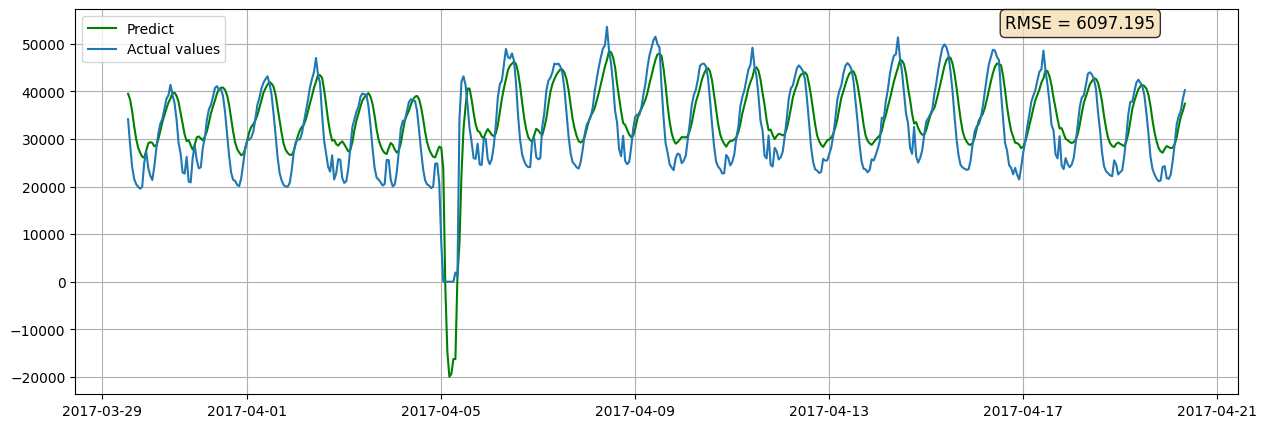

In [20]:
# Возьмем С = 1, обучим на модель и проверим предсказание на тесте

C = 1
n_samples = 5
batch_size = 10
n_features = len(nonlinear_x(dataset["Users"].iloc[0]))

model = MyLassoRegression(C=C, n_samples=n_samples)
losses = model.fit(dataset["Users"], train_idx, batch_size=batch_size, max_iter=5000, lr=0.001)

predict = np.array([model.predict(dataset["Users"], idx) for idx in (test_idx)])
target = np.array(dataset["Users"].iloc[test_idx])

def plot_predict(series, predict, test_idx):
    plt.figure(figsize=(15,5))
    plt.plot(series['Time'].iloc[test_idx], predict, "g", label="Predict")

    plt.plot(series['Time'].iloc[test_idx], series['Users'].iloc[test_idx], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

    rmse = RMSE(series['Users'].iloc[test_idx], predict)

    plt.text(0.80, 0.95, f'RMSE = {rmse:.3f}', transform=plt.gca().transAxes,
         fontsize=12, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

plot_predict(dataset, predict, test_idx)

### А теперь составим ряд только из предсказанных значений и сравним точность

In [21]:
start_idx = int(len(dataset)*0.8)

predict_list = list(dataset["Users"].iloc[start_idx-n_samples:start_idx])

target_list = list(dataset["Users"].iloc[start_idx-n_samples:])

for i in range(len(dataset) - start_idx):
    predict_list.append(0)
    pred = model.predict(predict_list, len(predict_list)-1)
    predict_list[-1] = pred

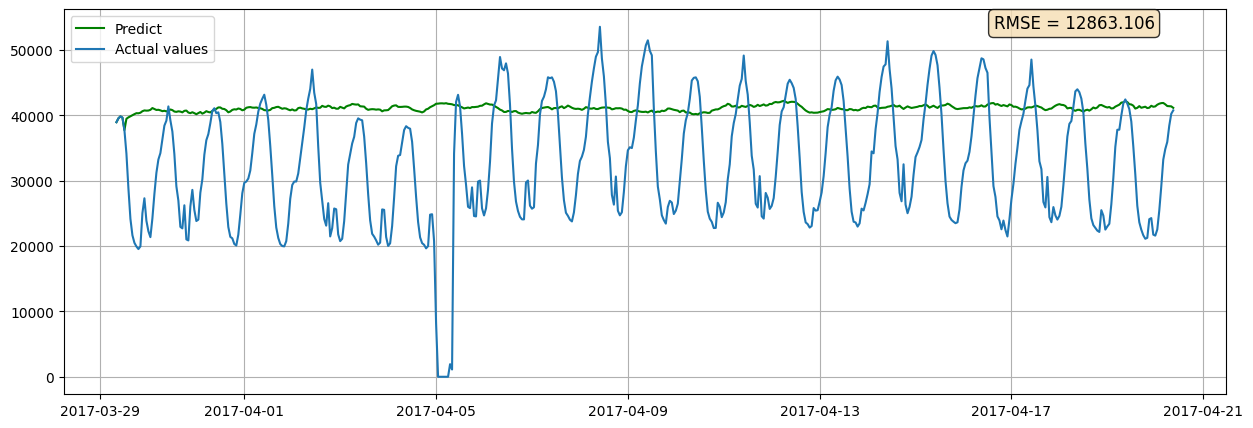

In [22]:
def plot_predict_line(x_axis, target_list, predict_list):
    plt.figure(figsize=(15,5))
    plt.plot(x_axis, predict_list, "g", label="Predict")

    plt.plot(x_axis, target_list, label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

    rmse = RMSE(np.array(target_list), np.array(predict_list))

    plt.text(0.80, 0.95, f'RMSE = {rmse:.3f}', transform=plt.gca().transAxes,
         fontsize=12, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

plot_predict_line(dataset["Time"].iloc[start_idx-n_samples:], target_list, predict_list)

### Попробуем сильно увеличить обучающую выборку, посмотрим как это повлияет на результат

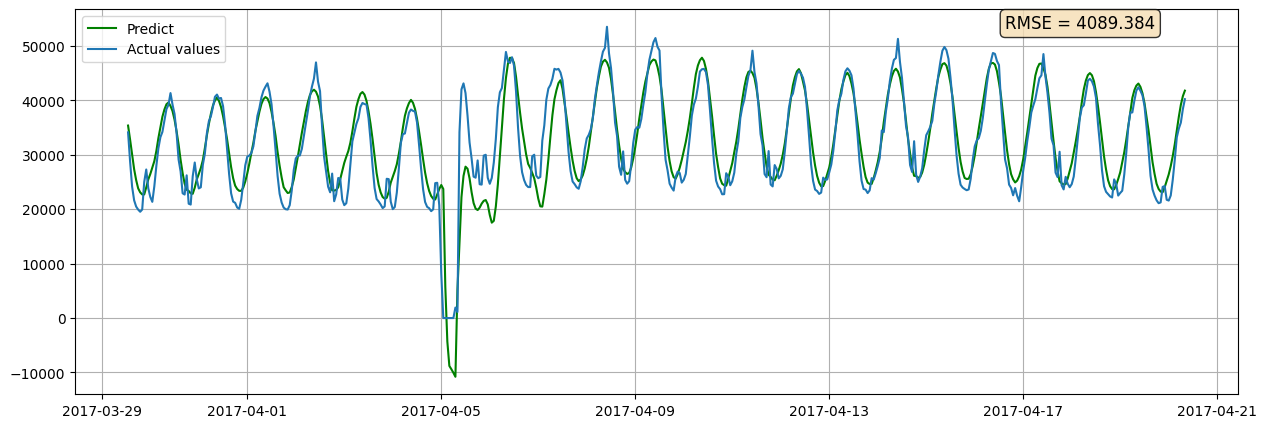

In [23]:
C = 1
n_samples = 50
batch_size = 10

train_idx, test_idx = train_test_series_split(dataset["Users"], n_samples, batch_size=batch_size)

model = MyLassoRegression(C=C, n_samples=n_samples)
losses = model.fit(dataset["Users"], train_idx, batch_size=batch_size, max_iter=5000, lr=0.001)

predict = np.array([model.predict(dataset["Users"], idx) for idx in (test_idx)])
target = np.array(dataset["Users"].iloc[test_idx])

plot_predict(dataset, predict, test_idx)

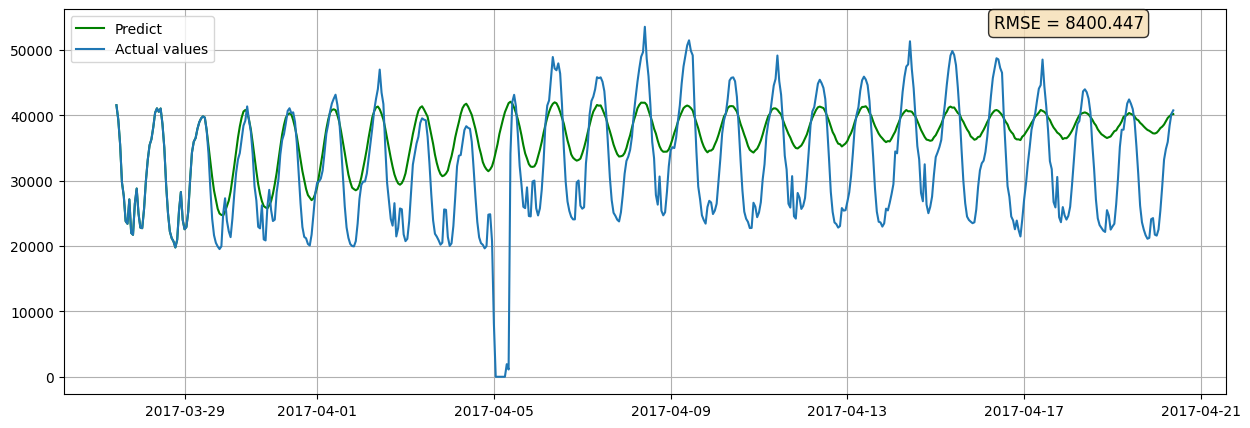

In [24]:
start_idx = int(len(dataset)*0.8)
predict_list = list(dataset["Users"].iloc[start_idx-n_samples:start_idx])
target_list = list(dataset["Users"].iloc[start_idx-n_samples:])

for i in range(len(dataset) - start_idx):
    predict_list.append(0)
    pred = model.predict(predict_list, len(predict_list)-1)
    predict_list[-1] = pred

plot_predict_line(dataset["Time"].iloc[start_idx-n_samples:], target_list, predict_list)

### Выводы по линейной регрессии:

1) Модель хорошо предсказывает 1 следующее значение, если берет в расчет настоящие (не предсказанные) предыдущие
2) Модель перестает быть похожей на настоящий график (не улавливает сезонность) если для расчета следующего значения использовались предсказания предыдущих
3) Модель может использоваться в реальном времени, так как для предсказания нужно < 1 секунды
4) Артефакт линейной регрессии в виде сглаживания линии предсказания из-за накопления ошибок сложно преодолеть, только если искусственно вводить тренды в обучение, что не желательно, мы ожидали, что модель сама это выучит

## Лучшая из мл архитектур для любой задачи, это градиентный бустинг, попробуем его применить для предсказания ряда

In [26]:
from xgboost import XGBRegressor

n_samples_5 = 5
n_samples_50 = 50

# Составим обучающую выборку по аналогии с тем, как это делалось для регрессии
train_idx_5, val_idx_5, test_idx_5 = train_test_series_split(dataset["Users"], n_samples_5, batch_size=batch_size, val=True)
train_idx_50, val_idx_50, test_idx_50 = train_test_series_split(dataset["Users"], n_samples_50, batch_size=batch_size, val=True)
print("Выборки разделены")
# Предсказание по 5 предыдущим
def form_matrix(series, idx_list, n_samples, scaling=True):
    x_matrix = []
    y_matrix = []

    for idx in idx_list:
        if scaling == True:
            x_line, y_line = form_train_vector(series["Users"], n_samples, idx)
            x_matrix.append(x_line)
            y_matrix.append(y_line)
        else:
            x_line, y_line = form_train_vector_nc(series["Users"], n_samples, idx)
            x_matrix.append(x_line)
            y_matrix.append(y_line)

    return np.array(x_matrix), np.array(y_matrix)

# Выборки по 5 предыдущим
x_train_5, y_train_5 = form_matrix(dataset, train_idx_5, n_samples_5)
x_val_5, y_val_5 = form_matrix(dataset, val_idx_5, n_samples_5)
x_test_5, y_test_5 = form_matrix(dataset, test_idx_5, n_samples_5)
# Выборки по 5 предыдущим без scaler
x_train_5_nc, y_train_5_nc = form_matrix(dataset, train_idx_5, n_samples_5, scaling=False)
x_val_5_nc, y_val_5_nc = form_matrix(dataset, val_idx_5, n_samples_5, scaling=False)
x_test_5_nc, y_test_5_nc = form_matrix(dataset, test_idx_5, n_samples_5, scaling=False)
# Выборки по 50 предыдущим
x_train_50, y_train_50 = form_matrix(dataset, train_idx_50, n_samples_50)
x_val_50, y_val_50 = form_matrix(dataset, val_idx_50, n_samples_50)
x_test_50, y_test_50 = form_matrix(dataset, test_idx_50, n_samples_50)
print("Составлены все подмассивы")

model_5 = XGBRegressor(
    booster = "gbtree",
    learning_rate = 0.001,
    max_depth = 10,
    n_estimators = 5000,
    n_jobs = -1,
    eval_metric = 'rmse',
    early_stopping_rounds = 50)

model_5_nc = XGBRegressor(
    booster = "gbtree",
    learning_rate = 0.003,
    max_depth = 2,
    n_estimators = 5000,
    n_jobs = -1,
    eval_metric = 'rmse',
    early_stopping_rounds = 50)

model_50 = XGBRegressor(
    booster = "gbtree",
    learning_rate = 0.001,
    max_depth = 5,
    n_estimators = 5000,
    n_jobs = -1,
    eval_metric = 'rmse',
    early_stopping_rounds = 50)

print("Начало обучения")
model_5.fit(x_train_5, y_train_5.T, eval_set = [(x_val_5, y_val_5.T)], verbose=200)
model_5_nc.fit(x_train_5_nc, y_train_5_nc.T, eval_set = [(x_val_5_nc, y_val_5_nc.T)], verbose=200)
model_50.fit(x_train_50, y_train_50.T, eval_set = [(x_val_50, y_val_50.T)], verbose=200)

print("Начало предикта")
predict_5 = list(model_5.predict(x_test_5))
predict_5_nc = list(model_5_nc.predict(x_test_5_nc))
predict_50 = list(model_50.predict(x_test_50))

Выборки разделены
Составлены все подмассивы
Начало обучения
[0]	validation_0-rmse:14231.93158
[200]	validation_0-rmse:11981.93544
[400]	validation_0-rmse:10258.93886
[600]	validation_0-rmse:8911.24153
[800]	validation_0-rmse:7844.23847
[1000]	validation_0-rmse:7037.04700
[1200]	validation_0-rmse:6425.70681
[1400]	validation_0-rmse:5964.08651
[1600]	validation_0-rmse:5632.29295
[1800]	validation_0-rmse:5404.39129
[2000]	validation_0-rmse:5253.73458
[2200]	validation_0-rmse:5161.08977
[2400]	validation_0-rmse:5100.18244
[2600]	validation_0-rmse:5074.59091
[2752]	validation_0-rmse:5073.43005
[0]	validation_0-rmse:14211.22488
[200]	validation_0-rmse:9434.99548
[400]	validation_0-rmse:6901.67087
[600]	validation_0-rmse:5153.31620
[800]	validation_0-rmse:4162.76908
[1000]	validation_0-rmse:3572.93709
[1200]	validation_0-rmse:3383.49171
[1363]	validation_0-rmse:3380.35511
[0]	validation_0-rmse:14274.26693
[200]	validation_0-rmse:11978.66066
[400]	validation_0-rmse:10039.06864
[600]	validation

### Предсказание на тестовой выборке

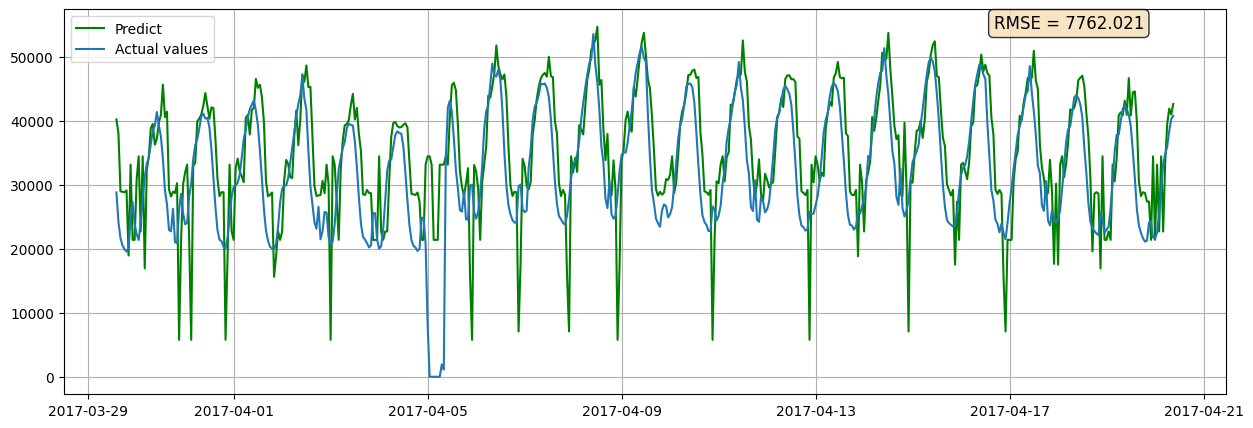

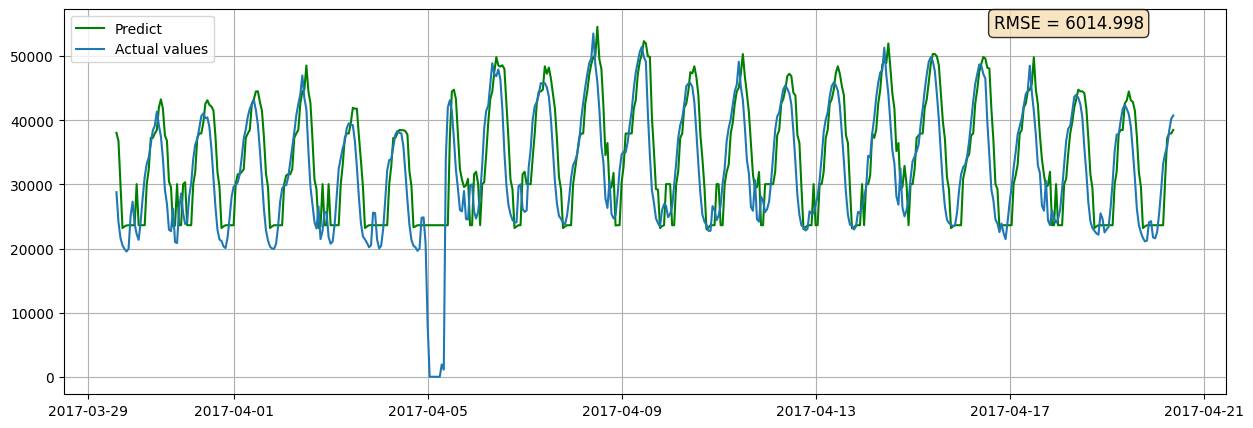

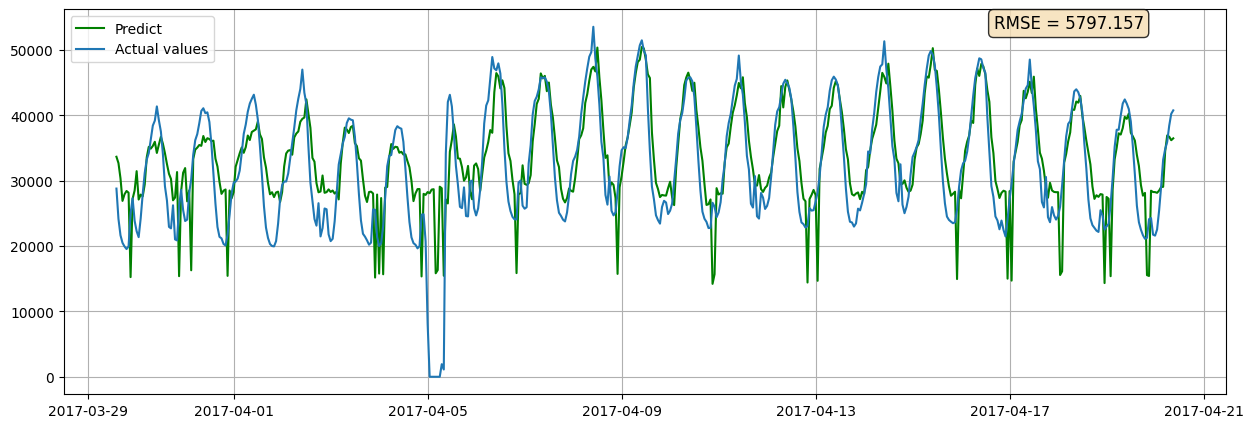

In [27]:
start_idx = int(len(dataset)*0.8)
target_list_5 = list(dataset["Users"].iloc[start_idx+1:])
target_list_50 = list(dataset["Users"].iloc[start_idx+1:])

plot_predict_line(dataset["Time"].iloc[start_idx+1:], target_list_5, predict_5)
plot_predict_line(dataset["Time"].iloc[start_idx+1:], target_list_5, predict_5_nc)
plot_predict_line(dataset["Time"].iloc[start_idx+1:], target_list_50, predict_50)

### Предсказание следующего значения на предыдущих предсказанных значениях

In [28]:
start_idx = int(len(dataset)*0.8)
predict_list_5 = list(dataset["Users"].iloc[start_idx-n_samples_5:start_idx])
target_list_5 = list(dataset["Users"].iloc[start_idx-n_samples_5:])

predict_list_5_nc = list(dataset["Users"].iloc[start_idx-n_samples_5:start_idx])
target_list_5_nc = list(dataset["Users"].iloc[start_idx-n_samples_5:])

predict_list_50 = list(dataset["Users"].iloc[start_idx-n_samples_50:start_idx])
target_list_50 = list(dataset["Users"].iloc[start_idx-n_samples_50:])

for idx in range(start_idx, len(dataset)):
    values = predict_list_5[-n_samples_5:]
    vector = form_boost_vector(values)
    vector = vector[np.newaxis, :]
    pred = model_5.predict(vector)
    predict_list_5.append(pred[0].item())

for idx in range(start_idx, len(dataset)):
    values = predict_list_5_nc[-n_samples_5:]
    vector = form_boost_vector_nc(values)
    vector = vector[np.newaxis, :]
    pred = model_5_nc.predict(vector)
    predict_list_5_nc.append(pred[0].item())

for idx in range(start_idx, len(dataset)):
    values = predict_list_50[-n_samples_50:]
    vector = form_boost_vector(values)
    vector = vector[np.newaxis, :]
    pred = model_50.predict(vector)
    predict_list_50.append(pred[0].item())

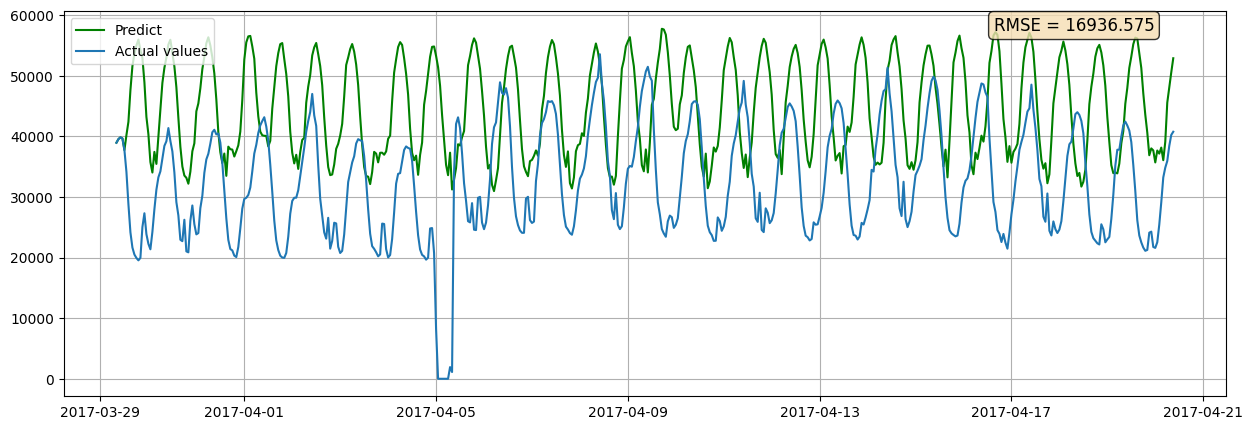

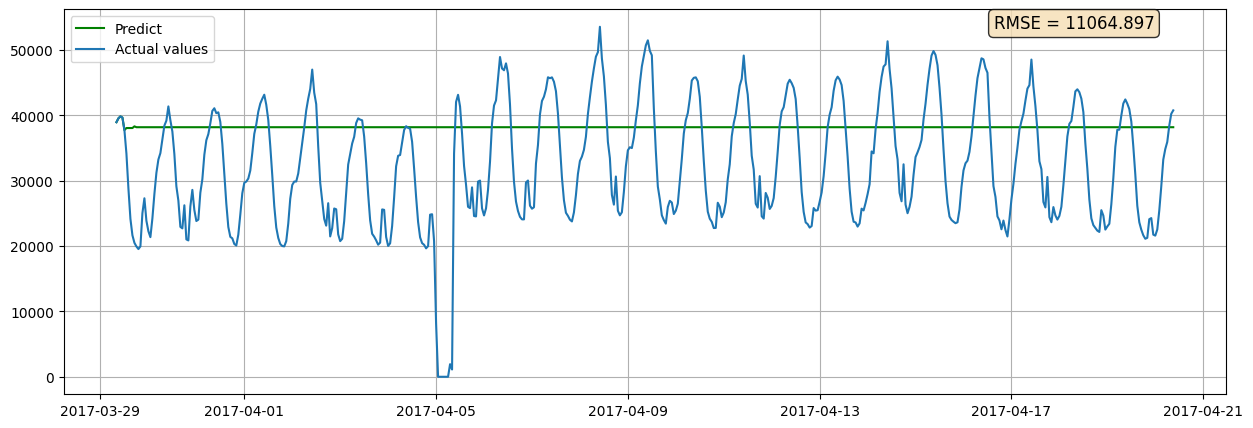

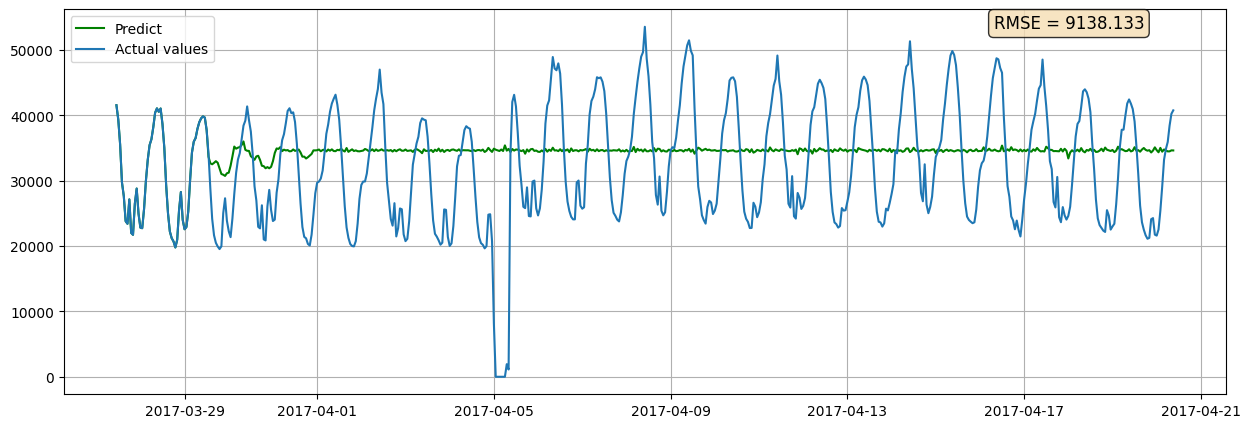

In [29]:
plot_predict_line(dataset["Time"].iloc[start_idx-n_samples_5:], target_list_5, predict_list_5)
plot_predict_line(dataset["Time"].iloc[start_idx-n_samples_5:], target_list_5_nc, predict_list_5_nc)
plot_predict_line(dataset["Time"].iloc[start_idx-n_samples_50:], target_list_50, predict_list_50)

### Выводы по решающим деревьям
1) Следующее значение деревья предсказывают еще лучше, чем регрессия, если подать на вход правильные значения
2) Неожиданным оказалось, что при инициализации деревьев в XGBoost при передаче как отмасштабированных, так и не измененных фич, результат оказывает абсолютно одинаковый (поэтому я их использовал в последнем эксперименте как одна модель, но с разными параметрами)
3) Все правила построения бустинга показали свою применимость (базовый lr=0.003, недообученные деревья) выдали лучший результат
4) Очень быстро накапливаются ошибки при погнозировании значений по спрогнозирвоанным, поэтому корректно использовать данные модели можно только для предсказания следующего значения

## Проведем эксперимент по работе с данным рядом используя нейронные сети.
В качестве нейронной сети воспользуемся рекуррентной архитектурой. Выберем GRU блоки как адаптацию LSTM, с более быстрым обучением и меньшим числом подбираемых параметров.